In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [89]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [90]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [91]:
df['Date']=df.index

In [92]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [93]:
df=df.loc[mask]

In [94]:
df=df.loc[mask]

In [95]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [96]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [97]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [98]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [99]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [100]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [101]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 400)          323200    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 50, 400)          961600    
 onal)                                                           
                                                                 
 global_max_pooling1d_6 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 100)               40100     
                                                           

In [102]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [103]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [104]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
53/53 [==============================] - 45s 719ms/step - loss: 296.7817 - mae: 12.8312 - mse: 296.7817 - val_loss: 1638.2882 - val_mae: 27.8633 - val_mse: 1638.2882
Epoch 2/100
53/53 [==============================] - 36s 683ms/step - loss: 291.4723 - mae: 12.6910 - mse: 291.4723 - val_loss: 1635.1516 - val_mae: 27.8092 - val_mse: 1635.1516
Epoch 3/100
53/53 [==============================] - 35s 668ms/step - loss: 290.7917 - mae: 12.6808 - mse: 290.7917 - val_loss: 1635.3795 - val_mae: 27.8109 - val_mse: 1635.3795
Epoch 4/100
53/53 [==============================] - 35s 662ms/step - loss: 290.5276 - mae: 12.6702 - mse: 290.5276 - val_loss: 1637.7020 - val_mae: 27.8458 - val_mse: 1637.7020
Epoch 5/100
53/53 [==============================] - 35s 669ms/step - loss: 290.0981 - mae: 12.6420 - mse: 290.0981 - val_loss: 1633.5129 - val_mae: 27.7732 - val_mse: 1633.5129
Epoch 6/100
53/53 [==============================] - 35s 668ms/step - loss: 290.0748 - mae: 12.6521 - mse: 290

Bi-directional GRU

In [105]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_7 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_21 (Dense)            (None, 100)               40100     
                                                           

In [106]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [107]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [108]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
53/53 [==============================] - 38s 591ms/step - loss: 298.3365 - mae: 12.8965 - mse: 298.3365 - val_loss: 1642.0034 - val_mae: 27.9152 - val_mse: 1642.0034
Epoch 2/100
53/53 [==============================] - 30s 569ms/step - loss: 291.1785 - mae: 12.6971 - mse: 291.1785 - val_loss: 1635.6633 - val_mae: 27.8130 - val_mse: 1635.6633
Epoch 3/100
53/53 [==============================] - 30s 566ms/step - loss: 290.6810 - mae: 12.6885 - mse: 290.6810 - val_loss: 1635.6125 - val_mae: 27.8110 - val_mse: 1635.6125
Epoch 4/100
53/53 [==============================] - 30s 566ms/step - loss: 290.3729 - mae: 12.6658 - mse: 290.3729 - val_loss: 1638.0743 - val_mae: 27.8504 - val_mse: 1638.0743
Epoch 5/100
53/53 [==============================] - 30s 564ms/step - loss: 289.8809 - mae: 12.6434 - mse: 289.8809 - val_loss: 1633.1416 - val_mae: 27.7481 - val_mse: 1633.1416
Epoch 6/100
53/53 [==============================] - 30s 565ms/step - loss: 289.8475 - mae: 12.6606 - mse: 289

Predictions

In [109]:
train_idx[:T+1]=False

In [110]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [111]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [112]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [113]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [114]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [115]:
last_train=train.iloc[-1]['Prev Close']

In [116]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [117]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

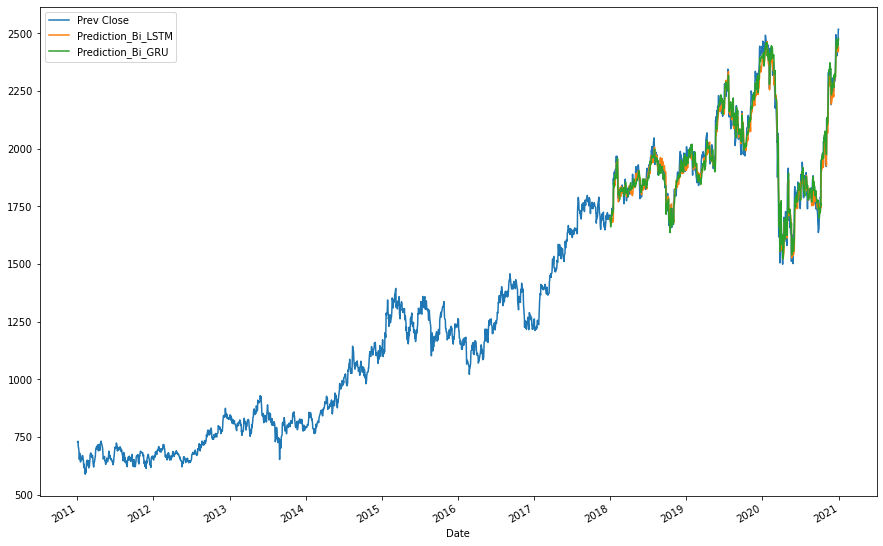

In [118]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

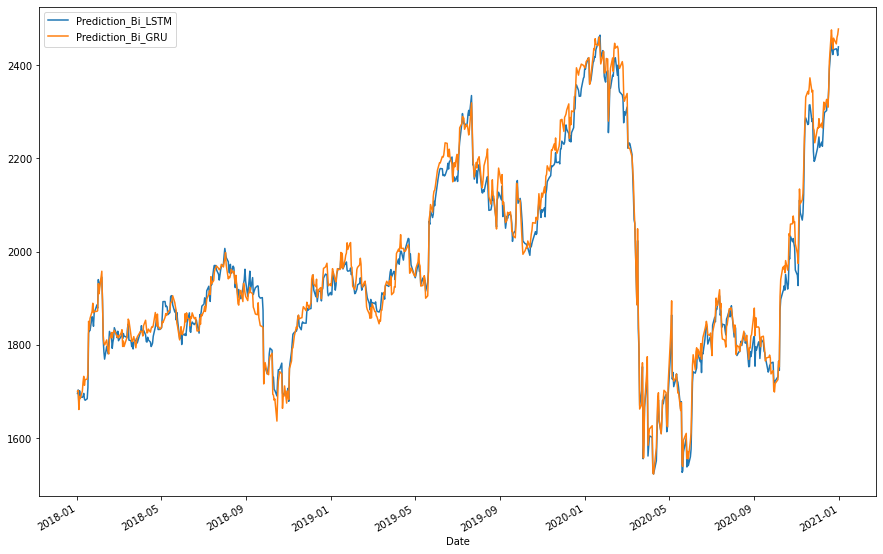

In [119]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [120]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [121]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

52.540013038349784


In [122]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

40.15275961386934


In [123]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.9422885840833205

In [124]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [125]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

49.00648248942955


In [126]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

36.645700673341835


In [127]:
r2_score(test['Prev Close'],pred_bi_gru)

0.9497902059259863